In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
import numpy as np 
import pandas as pd

In [10]:
import glob
filename = glob.glob("../input/bdm-2021-face/*.*")
filename[0] 

'../input/bdm-2021-face/622110140_4_0.jpg'

In [11]:
filename[0].split("_")

['../input/bdm-2021-face/622110140', '4', '0.jpg']

In [12]:
filename[0].split("_")[-1].split(".")[0] 

'0'

In [13]:
label = np.array([float(item.split("_")[-1].split(".")[0]) for item in filename])

In [14]:
!mkdir train
!mkdir train/male
!mkdir train/female

In [15]:
import shutil
for i in range(len(label)):
    if label[i] == 0:
        shutil.copy(filename[i], '/kaggle/working/train/male')
    else:
        shutil.copy(filename[i], '/kaggle/working/train/female')

In [16]:
!mkdir test
!mkdir test/male
!mkdir test/female

In [17]:
import glob
filemale = np.array(glob.glob("./train/male/*.*"))
filefemale = np.array(glob.glob("./train/female/*.*"))

In [18]:
midx = np.random.randint(len(filemale), size = 4)
fidx = np.random.randint(len(filefemale), size = 2)

In [19]:
for i in fidx:
    shutil.move(filefemale[i],'./test/female/')
for i in midx:
    shutil.move(filemale[i],'./test/male/')

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        #rescale = 1.0/255.0,   # Intensity Normalized
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,   # randomly flip images
        validation_split=0.2)

2021-09-20 22:18:36.345676: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-20 22:18:36.345795: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [22]:
train_dir = './train'

batch_size = 5 # ส่งไปเทรนทีละ5 เพราะมีรูป ผญ 15 คน
img_height = 100
img_width  = 100
train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = data_generator.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation') # set as validation data

Found 63 images belonging to 2 classes.
Found 15 images belonging to 2 classes.


In [23]:
train_generator.class_indices

{'female': 0, 'male': 1}

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
# preparing the layers in the Convolutional Deep Neural Network
def create_model():
    tf.random.set_seed(0)
    tf.compat.v1.reset_default_graph() # Clear Model
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = train_generator.image_shape)) 
    # Conv2Dตัวสกัดfilters
    model.add(MaxPooling2D(pool_size = (2, 2)))
    #ย่อภาพลงมา
    
    model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
   
    
    model.add(Conv2D(filters = 8, kernel_size = (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(rate = 0.15))
    
    model.add(Flatten())
    #ตบถาพให้แบนเป็น2มิติลงมา
    
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 16, activation = 'relu'))
    model.add(Dropout(rate = 0.1))
    
    model.add(Dense(units = 1, activation = 'sigmoid'))
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [25]:
model = create_model()

2021-09-20 22:19:55.223548: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-20 22:19:55.228957: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-20 22:19:55.229000: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-20 22:19:55.229033: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (a2557bec85bc): /proc/driver/nvidia/version does not exist
2021-09-20 22:19:55.231907: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [26]:
fitted_model = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 99)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-09-20 22:20:05.027274: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-20 22:20:05.032355: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299995000 Hz


Epoch 1/99
12/12 [==============================] - 7s 562ms/step - loss: 3.5692 - accuracy: 0.4606 - val_loss: 0.8349 - val_accuracy: 0.7333
Epoch 2/99
12/12 [==============================] - 5s 432ms/step - loss: 0.6161 - accuracy: 0.7367 - val_loss: 0.8378 - val_accuracy: 0.7333
Epoch 3/99
12/12 [==============================] - 5s 458ms/step - loss: 0.7780 - accuracy: 0.5234 - val_loss: 0.6657 - val_accuracy: 0.8000
Epoch 4/99
12/12 [==============================] - 5s 437ms/step - loss: 0.6767 - accuracy: 0.7110 - val_loss: 0.7073 - val_accuracy: 0.5333
Epoch 5/99
12/12 [==============================] - 5s 429ms/step - loss: 0.5582 - accuracy: 0.6274 - val_loss: 0.6759 - val_accuracy: 0.6667
Epoch 6/99
12/12 [==============================] - 5s 476ms/step - loss: 0.5501 - accuracy: 0.6826 - val_loss: 0.6548 - val_accuracy: 0.6667
Epoch 7/99
12/12 [==============================] - 5s 444ms/step - loss: 0.5244 - accuracy: 0.7963 - val_loss: 0.5984 - val_accuracy: 0.6000
Epoch 

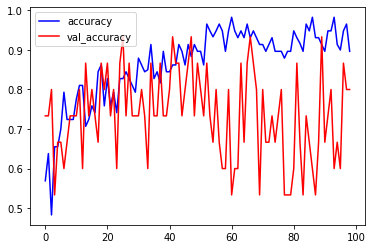

In [27]:
import matplotlib.pyplot as plt
# plotting accuracy and validation accuracy
accuracy = fitted_model.history['accuracy']
val_accuracy = fitted_model.history['val_accuracy']
plt.plot(range(len(accuracy)), accuracy, 'b-', label = 'accuracy')
plt.plot(range(len(val_accuracy)), val_accuracy, 'r-', label = 'val_accuracy')
plt.legend()

In [29]:
import glob
filefemale = glob.glob("./test/female/*.*")
filemale = glob.glob("./test/male/*.*")

In [30]:
from tensorflow.keras.preprocessing import image
# testing the model
plabel = []
for filename in filefemale:
    test_image = image.load_img(filename, target_size = (img_height, img_width))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    plabel.append(np.round(model.predict(test_image)[0][0]))
plabel = np.array(plabel)
sum(plabel==0)/len(plabel)

1.0

In [31]:
plabel = []
for filename in filemale:
    test_image = image.load_img(filename, target_size = (img_height, img_width))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    plabel.append(np.round(model.predict(test_image)[0][0]))
plabel = np.array(plabel)
sum(plabel==1)/len(plabel)

1.0